<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/convenience_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利便性
- input:
    - convenience_store.csv
        - コンビニ店舗位置
    - supermarket.csv
        - スーパー店舗位置
    - train_station.csv
        - 最寄り駅の位置
    - train_station_route.csv
        - 主要駅までの平均所要時間
    - navitime_master.csv
        - 各種店舗の位置
    - eat_drink_master.csv
        - 飲食店の位置
    - various_shops_master.csv
        - 各種店舗の位置
- output:
    - convenience_score.csv
        - 買い物スコア
        - 駅スコア
        - 飲食店スコア
        - 利便性スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### 地理マスタ

In [5]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [6]:
store_type_list = []

### コンビニ

In [7]:
df_convini_master = pd.read_csv(os.path.join(DIR_NAME, 'convenience_store.csv'))[['name', 'lat', 'lng']]
df_convini_master['施設分類'] = 'コンビニ'
df_convini_master = df_convini_master.rename(columns={'name':'名称', 'lat':'緯度', 'lng':'経度'})
print(df_convini_master.shape)
store_type_list.append('コンビニ')

(6405, 4)


### スーパー

In [8]:
df_super_master = pd.read_csv(os.path.join(DIR_NAME, 'supermarket.csv'))[['name', 'lat', 'lng']]
df_super_master['施設分類'] = 'スーパー'
df_super_master = df_super_master.rename(columns={'name':'名称', 'lat':'緯度', 'lng':'経度'})
print(df_super_master.shape)
store_type_list.append('スーパー')

(2060, 4)


### 最寄駅

In [9]:
df_station_master = pd.read_csv(os.path.join(DIR_NAME, 'train_station.csv'))[['no', 'name', 'lat', 'lng']]
df_station_master = df_station_master.rename(columns={'no':'town_id', 'name':'最寄駅'})
print(df_station_master.shape)

(3141, 4)


### 主要駅までの平均所要時間

In [10]:
major_station = ['東京駅', '上野駅', '池袋駅', '新宿駅', '渋谷駅', '品川駅']
df_station_route = pd.read_csv(os.path.join(DIR_NAME, 'train_station_route.csv'))[['no'] + major_station].rename(columns={'no': 'town_id'})
print(df_station_route.shape)

(3141, 7)


In [11]:
df_station_route['平均所要(時間)'] = df_station_route[major_station].mean(axis=1).round(0)
df_station_route = df_station_route[['town_id', '平均所要(時間)']]

### 各種店舗(1)
- '商店街', '銭湯', 'カラオケ', 'ネットカフェ', 'クリーニング'

In [12]:
df_navitime_org = pd.read_csv(os.path.join(DIR_NAME, 'navitime_master.csv'))[['名称', 'データ元', '緯度', '経度']]
print(df_navitime_org.shape)

df_store = df_navitime_org[
    df_navitime_org['データ元'].isin(['商店街', '銭湯', 'カラオケ', 'ネットカフェ', 'クリーニング'])
].rename(columns={'データ元': '施設分類'}).reset_index(drop=True)
print(df_store.shape)

store_type_list += list(df_store['施設分類'].unique())

(7854, 4)
(2355, 4)


### 各種店舗(2)
- '本DVD', '衣料品', 'ビューティーサロン', '100円ショップ'

In [13]:
df_various_shops = pd.read_csv(os.path.join(DIR_NAME, 'various_shops_master.csv'))
print(df_various_shops.shape)

store_type_list += list(df_various_shops['施設分類'].unique())

(21519, 6)


### 飲食店
- 'カフェ', 'カフェ(チェーン店)', 'ファストフード', 'レストラン', 'レストラン(チェーン店)', '飲み屋'

In [14]:
df_eat_drink_org = pd.read_csv(os.path.join(DIR_NAME, 'eat_drink_master.csv'))[['名称', '施設分類', '緯度', '経度']]
df_eat_drink_org = df_eat_drink_org[
    df_eat_drink_org['施設分類'] != 'ネットカフェ'
].reset_index(drop=True)
print(df_eat_drink_org.shape)

store_type_list += list(df_eat_drink_org['施設分類'].unique())

(24260, 4)


In [15]:
df_store_master = pd.concat([
    df_convini_master,
    df_super_master,
    df_store,
    df_various_shops,
    df_eat_drink_org
]).reset_index(drop=True)
print(df_store_master.shape)

(56599, 6)


In [16]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.02) &    # 約2km以内
            ((_df_cat['経度'] - lon).abs() < 0.02)      # 約2km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

### スコア

In [17]:
%%time
radius = 0.5    # 0.5km以内の施設の数
for store in store_type_list:
    df_geo_master[f'{store}(数)'] = get_value_of_nearest_facility(df_geo_master, df_store_master, store, 'count', radius)
    print(store)

コンビニ
スーパー
商店街
銭湯
カラオケ
ネットカフェ
クリーニング
本DVD
衣料品
ビューティーサロン
100円ショップ
カフェ
カフェ(チェーン店)
ファストフード
レストラン
レストラン(チェーン店)
飲み屋
CPU times: user 3min 25s, sys: 2.14 s, total: 3min 27s
Wall time: 3min 35s


In [18]:
# 最寄駅からの距離
geo_master_len = len(df_geo_master)
df_geo_master = pd.merge(df_geo_master, df_station_master, on='town_id', how='left')
assert len(df_geo_master) == geo_master_len

df_geo_master['最寄駅(距離)'] = df_geo_master.apply(lambda x: get_distance(x['緯度'], x['経度'], x['lat'], x['lng']), axis=1)
df_geo_master = df_geo_master.drop(columns=['lat', 'lng'])

In [19]:
# 主要駅までの平均所要時間
df_geo_master = pd.merge(df_geo_master, df_station_route, on='town_id', how='left')
assert len(df_geo_master) == geo_master_len

max_time = df_geo_master['平均所要(時間)'].max() + 5
df_geo_master['平均所要(時間)'] = df_geo_master['平均所要(時間)'].fillna(max_time).astype(int)

In [20]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 26)


,town_id,市区町村名,町名,町丁目,緯度,経度,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),本DVD(数),衣料品(数),ビューティーサロン(数),100円ショップ(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅,最寄駅(距離),平均所要(時間)
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,72,3,0,0,2,0,0,3,24,31,1,8,4,1,22,0,31,東京駅,0.036657,16
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,54,1,0,0,0,0,0,3,33,22,1,11,5,2,23,0,36,東京駅,0.358574,16
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,46,1,0,1,2,0,0,2,38,38,1,14,5,2,24,0,39,有楽町駅,0.219467,20
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,37,1,0,1,0,0,1,3,14,23,0,8,8,1,18,0,30,大手町駅,0.308061,20
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,45,3,0,0,0,0,2,3,11,21,0,7,7,1,18,0,25,大手町駅,0.446996,20


In [21]:
feature_list = [col for col in df_geo_master.columns if col.endswith(')')]

コンビニ(数)


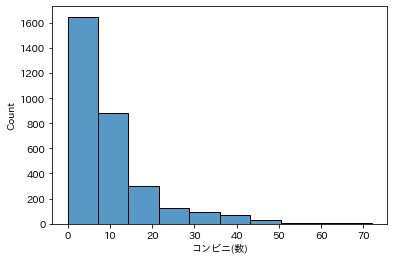

スーパー(数)


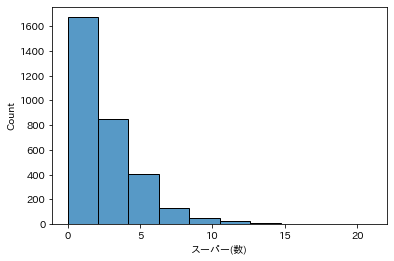

商店街(数)


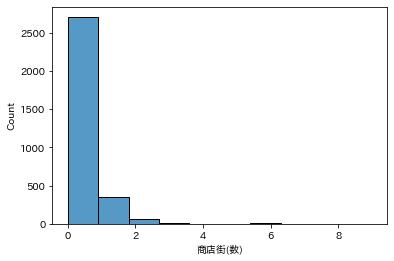

銭湯(数)


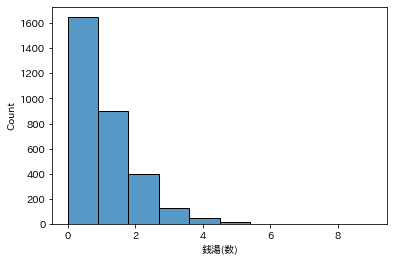

カラオケ(数)


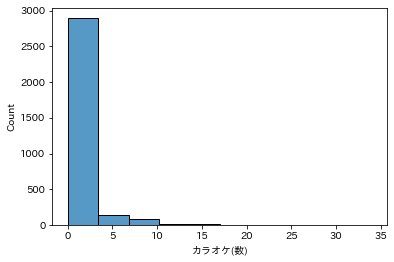

ネットカフェ(数)


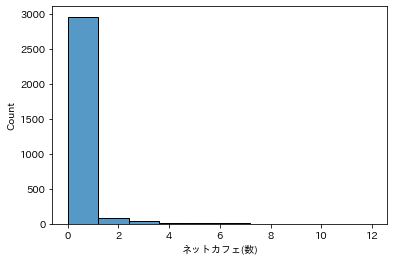

クリーニング(数)


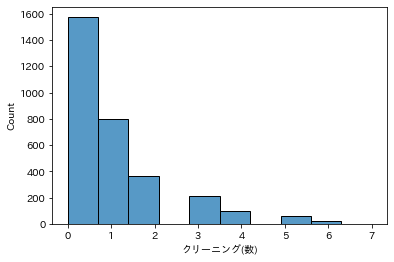

本DVD(数)


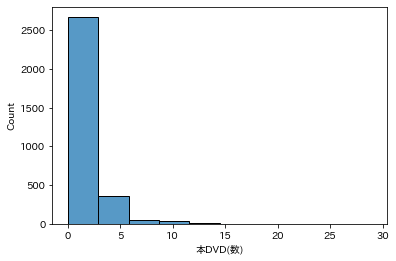

衣料品(数)


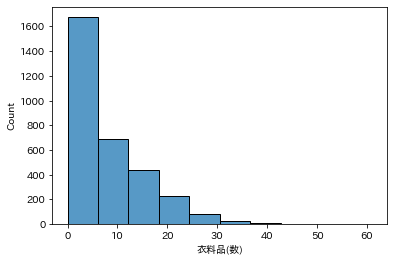

ビューティーサロン(数)


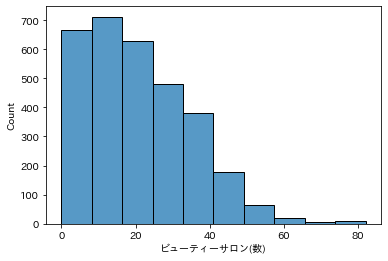

100円ショップ(数)


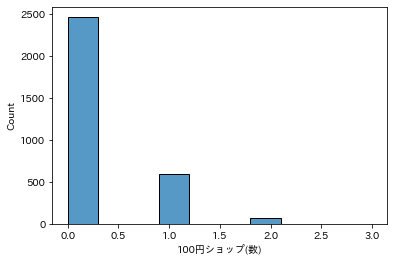

カフェ(数)


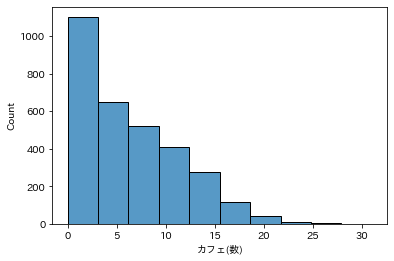

カフェ(チェーン店)(数)


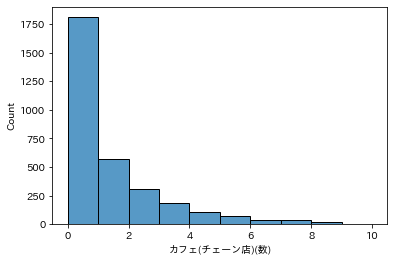

ファストフード(数)


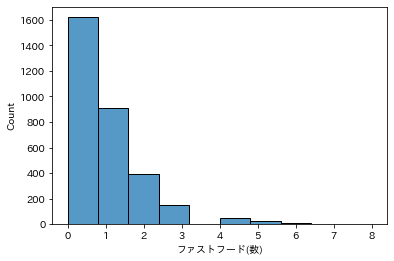

レストラン(数)


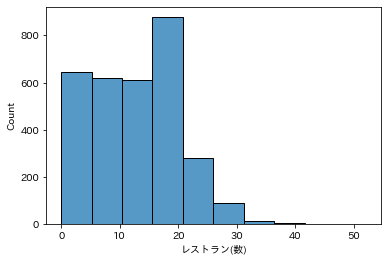

レストラン(チェーン店)(数)


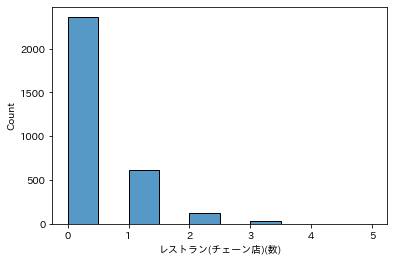

飲み屋(数)


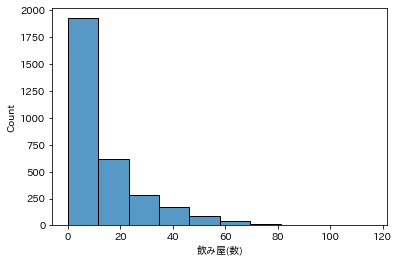

最寄駅(距離)


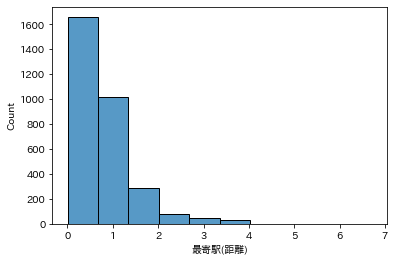

平均所要(時間)


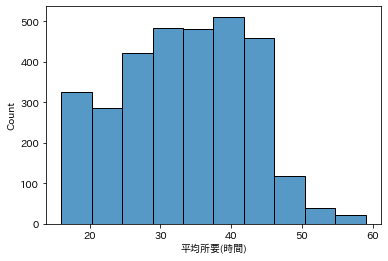

In [22]:
for feature in feature_list:
    print(feature)
    sns.histplot(df_geo_master[feature], bins=10)
    plt.show()

In [23]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

In [24]:
def plot_score(df_master, score_name, sr_source=None):
    if sr_source is not None:
        sns.histplot(sr_source, bins=20)
        plt.show()
    sns.histplot(df_master[score_name], bins=20)
    plt.show()
    print(df_master[score_name].describe())

In [25]:
for feature in feature_list:
    if feature.endswith('(距離)') or feature.endswith('(時間)'):
        df_geo_master[f'{feature}レベル'] = rank_score(df_geo_master[feature]*(-1)).round(2)
    else:
        df_geo_master[f'{feature}レベル'] = rank_score(df_geo_master[feature]).round(2)

In [26]:
feature_list

['コンビニ(数)',
 'スーパー(数)',
 '商店街(数)',
 '銭湯(数)',
 'カラオケ(数)',
 'ネットカフェ(数)',
 'クリーニング(数)',
 '本DVD(数)',
 '衣料品(数)',
 'ビューティーサロン(数)',
 '100円ショップ(数)',
 'カフェ(数)',
 'カフェ(チェーン店)(数)',
 'ファストフード(数)',
 'レストラン(数)',
 'レストラン(チェーン店)(数)',
 '飲み屋(数)',
 '最寄駅(距離)',
 '平均所要(時間)']

### 買い物スコア

In [27]:
score_name_list = []
score_name = '買い物スコア'
score_name_list.append(score_name)

score_list = [
    df_geo_master['コンビニ(数)レベル'] * 0.5,
    df_geo_master['スーパー(数)レベル'] * 1.0,
    df_geo_master['商店街(数)レベル'] * 0.7,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score).round(2)

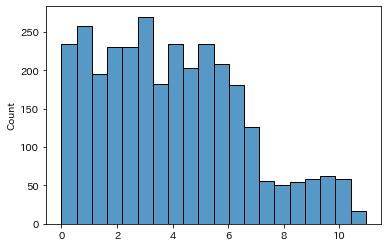

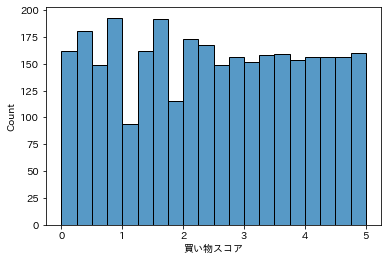

count    3145.000000
mean        2.481975
std         1.454528
min         0.000000
25%         1.250000
50%         2.480000
75%         3.740000
max         5.000000
Name: 買い物スコア, dtype: float64


In [28]:
plot_score(df_geo_master, score_name, _tmp_score)

### 駅スコア

In [29]:
score_name = '駅スコア'
score_name_list.append(score_name)

score_list = [
    df_geo_master['最寄駅(距離)レベル'] * 0.7,
    df_geo_master['平均所要(時間)レベル'] * 1.0,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score).round(2)

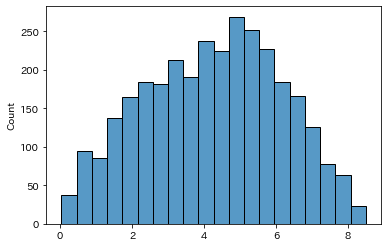

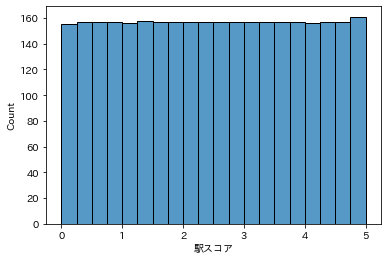

count    3141.000000
mean        2.499602
std         1.444327
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 駅スコア, dtype: float64


In [30]:
plot_score(df_geo_master, score_name, _tmp_score)

### 飲食店スコア
'カフェ(数)',
 'カフェ(チェーン店)(数)',
 'ファストフード(数)',
 'レストラン(数)',
 'レストラン(チェーン店)(数)',
 '飲み屋(数)',

In [31]:
score_name = '飲食店スコア'
score_name_list.append(score_name)

score_list = [
    df_geo_master['カフェ(数)レベル'] * 0.7,
    df_geo_master['カフェ(チェーン店)(数)レベル'] * 0.7,
    df_geo_master['ファストフード(数)レベル'] * 0.5,
    df_geo_master['レストラン(数)レベル'] * 1.0,
    df_geo_master['レストラン(チェーン店)(数)レベル'] * 0.7,
    df_geo_master['飲み屋(数)レベル'] * 0.5,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score).round(2)

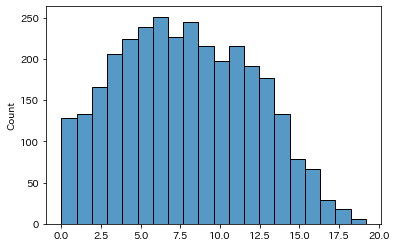

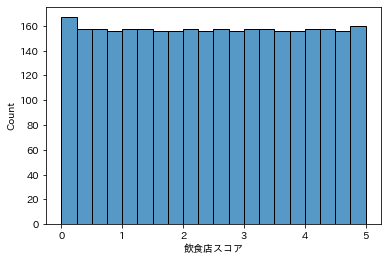

count    3145.000000
mean        2.488779
std         1.450477
min         0.000000
25%         1.230000
50%         2.490000
75%         3.740000
max         5.000000
Name: 飲食店スコア, dtype: float64


In [32]:
plot_score(df_geo_master, score_name, _tmp_score)

In [33]:
score_name = '利便性スコア'
score_name_list.append(score_name)

score_list = [
    df_geo_master['買い物スコア'] * 1.0,
    df_geo_master['駅スコア'] * 1.0,
    df_geo_master['飲食店スコア'] * 1.0,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score).round(2)

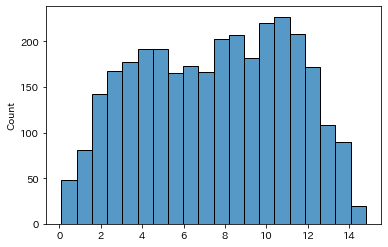

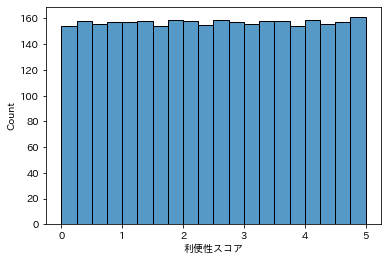

count    3141.000000
mean        2.499952
std         1.444042
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 利便性スコア, dtype: float64


In [34]:
plot_score(df_geo_master, score_name, _tmp_score)

In [35]:
df_geo_master['最寄駅(距離)'] = df_geo_master['最寄駅(距離)'].round(3)

In [36]:
df_geo_master.head()

,town_id,市区町村名,町名,町丁目,緯度,経度,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),本DVD(数),衣料品(数),ビューティーサロン(数),100円ショップ(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅,最寄駅(距離),平均所要(時間),コンビニ(数)レベル,スーパー(数)レベル,商店街(数)レベル,銭湯(数)レベル,カラオケ(数)レベル,ネットカフェ(数)レベル,クリーニング(数)レベル,本DVD(数)レベル,衣料品(数)レベル,ビューティーサロン(数)レベル,100円ショップ(数)レベル,カフェ(数)レベル,カフェ(チェーン店)(数)レベル,ファストフード(数)レベル,レストラン(数)レベル,レストラン(チェーン店)(数)レベル,飲み屋(数)レベル,最寄駅(距離)レベル,平均所要(時間)レベル,買い物スコア,駅スコア,飲食店スコア,利便性スコア
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,72,3,0,0,2,0,0,3,24,31,1,8,4,1,22,0,31,東京駅,0.037,16,5.00,2.90,0.0,0.00,3.83,0.0,0.00,4.24,4.79,3.80,4.01,3.16,4.52,2.71,4.58,0.0,4.35,4.99,5.00,3.58,5.00,4.49,4.77
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,54,1,0,0,0,0,0,3,33,22,1,11,5,2,23,0,36,東京駅,0.359,16,4.99,0.89,0.0,0.00,0.00,0.0,0.00,4.24,4.97,2.87,4.01,3.92,4.72,4.10,4.68,0.0,4.51,3.90,5.00,2.29,4.88,4.77,4.42
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,46,1,0,1,2,0,0,2,38,38,1,14,5,2,24,0,39,有楽町駅,0.219,20,4.97,0.89,0.0,2.75,3.83,0.0,0.00,3.58,4.99,4.38,4.01,4.50,4.72,4.10,4.76,0.0,4.61,4.66,4.65,2.29,4.92,4.84,4.46
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,37,1,0,1,0,0,1,3,14,23,0,8,8,1,18,0,30,大手町駅,0.308,20,4.86,0.89,0.0,2.75,0.00,0.0,2.52,4.24,3.93,2.99,0.00,3.16,4.97,2.71,3.63,0.0,4.32,4.21,4.65,2.28,4.85,4.29,4.18
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,45,3,0,0,0,0,2,3,11,21,0,7,7,1,18,0,25,大手町駅,0.447,20,4.96,2.90,0.0,0.00,0.00,0.0,3.75,4.24,3.44,2.74,0.00,2.86,4.92,2.71,3.63,0.0,4.05,3.42,4.65,3.54,4.66,4.18,4.57


In [37]:
output_score_file = 'convenience_score.csv'

In [45]:
df_geo_master[
    ['town_id'] + feature_list + score_name_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False, encoding='utf-8_sig')

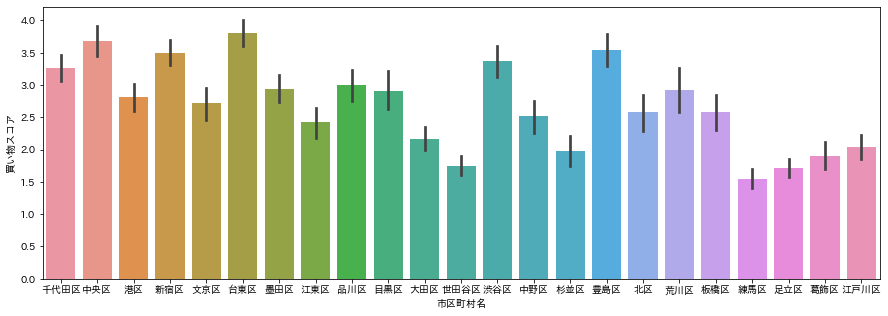

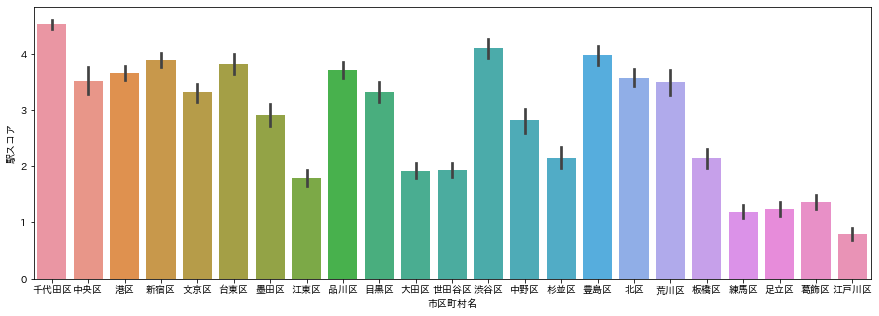

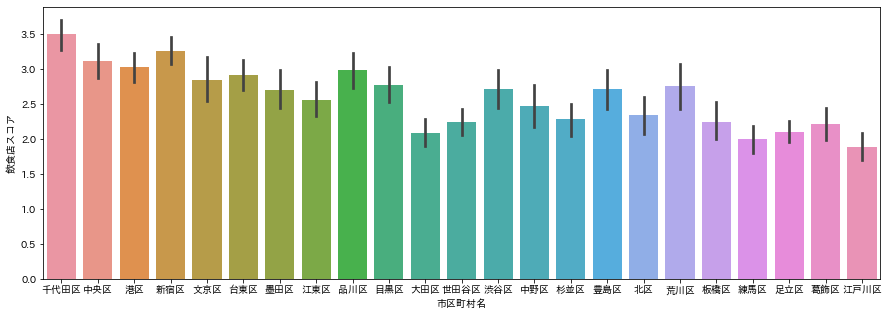

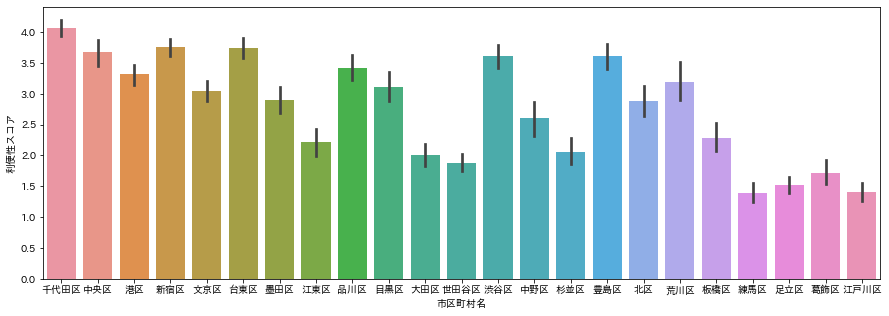

In [39]:
for score in score_name_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=score, data=df_geo_master)
    plt.show()

In [46]:
def get_score_rank(score_name):
    df_level = df_geo_master.copy()
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目', '最寄駅'] + feature_list + score_name_list
    ].reset_index(drop=True)
    return df_level

In [47]:
df_level = get_score_rank('利便性スコア')
df_level.head(10)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),本DVD(数),衣料品(数),ビューティーサロン(数),100円ショップ(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅(距離),平均所要(時間),買い物スコア,駅スコア,飲食店スコア,利便性スコア
0,新宿区,揚場町,揚場町,飯田橋駅,31,5,2,2,7,2,3,2,19,49,0,14,7,0,27,2,55,0.176,20,4.89,4.95,4.96,5.00
1,新宿区,神楽河岸,神楽河岸,飯田橋駅,33,4,2,1,7,2,1,4,19,50,0,14,7,0,17,2,52,0.184,20,4.80,4.94,4.85,5.00
2,新宿区,下宮比町,下宮比町,飯田橋駅,29,4,1,1,7,2,1,2,18,50,0,17,6,0,28,2,51,0.167,20,4.71,4.95,4.97,5.00
3,新宿区,神楽坂,神楽坂３丁目,飯田橋駅,27,8,1,2,5,1,3,2,24,47,0,14,7,0,27,2,59,0.373,20,4.92,4.77,4.96,5.00
4,新宿区,津久戸町,津久戸町,飯田橋駅,26,7,1,2,5,1,3,3,20,43,0,18,2,0,26,1,59,0.357,20,4.90,4.79,4.88,4.99
5,新宿区,大久保,大久保１丁目,新大久保駅,30,8,1,2,8,3,1,1,11,36,1,12,2,2,20,0,44,0.489,18,4.93,4.73,4.64,4.99
6,台東区,上野,上野６丁目,御徒町駅,51,12,2,2,11,10,3,4,21,49,1,12,7,1,19,0,50,0.208,21,5.00,4.88,4.63,4.99
7,荒川区,西日暮里,西日暮里３丁目,西日暮里駅,19,8,2,2,3,0,1,5,25,37,0,25,3,0,20,0,58,0.247,21,4.98,4.85,4.38,4.98
8,新宿区,高田馬場,高田馬場１丁目,高田馬場駅,28,7,0,0,3,1,4,8,29,56,1,19,5,2,20,1,69,0.333,18,4.40,4.89,4.99,4.98
9,中野区,中野,中野４丁目,中野駅,24,5,1,0,1,0,0,4,19,17,0,7,4,1,23,1,42,0.389,24,4.79,4.47,4.90,4.97


In [48]:
df_level.tail(10)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),本DVD(数),衣料品(数),ビューティーサロン(数),100円ショップ(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅(距離),平均所要(時間),買い物スコア,駅スコア,飲食店スコア,利便性スコア
891,足立区,北加平町,北加平町,六町駅,2,1,0,0,0,0,0,0,3,6,0,1,0,0,2,0,0,0.620,47,0.68,0.76,0.11,0.20
892,世田谷区,宇奈根,宇奈根１丁目,久地駅,2,1,0,0,0,0,0,0,1,7,1,0,1,0,6,0,1,1.561,48,0.68,0.06,0.76,0.19
893,板橋区,新河岸,新河岸２丁目,戸田公園駅,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1.915,34,0.17,1.18,0.04,0.16
894,江戸川区,北篠崎,北篠崎１丁目,市川駅,2,1,0,1,0,0,2,0,0,4,0,0,0,0,5,0,0,1.418,40,0.68,0.54,0.17,0.16
895,世田谷区,砧公園,砧公園,用賀駅,0,0,0,0,0,0,0,0,0,2,0,1,0,0,4,0,0,1.318,36,0.00,1.16,0.19,0.14
896,練馬区,立野町,立野町,武蔵関駅,2,1,0,0,0,0,0,0,2,9,0,3,0,0,5,0,2,1.339,48,0.68,0.09,0.54,0.13
897,江戸川区,堀江町,堀江町,東京ディズニーランド・ステーション駅,2,1,0,0,0,0,0,0,0,4,0,2,0,0,0,0,1,0.951,54,0.68,0.25,0.18,0.10
898,葛飾区,金町浄水場,金町浄水場,柴又駅,0,0,0,0,0,0,0,0,0,1,0,2,0,0,2,0,0,0.698,54,0.00,0.51,0.18,0.06
899,大田区,京浜島,京浜島１丁目,昭和島駅,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.789,46,0.00,0.53,0.08,0.05
900,江戸川区,東篠崎町,東篠崎町,本八幡駅,0,0,0,0,0,0,0,0,2,6,0,2,0,0,6,0,0,3.027,43,0.00,0.12,0.33,0.03


In [57]:
get_score_rank('衣料品(数)').head(5)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),本DVD(数),衣料品(数),ビューティーサロン(数),100円ショップ(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅(距離),平均所要(時間),買い物スコア,駅スコア,飲食店スコア,利便性スコア
0,港区,台場,台場２丁目,東京テレポート駅,10,1,0,1,0,0,0,2,61,5,2,19,4,2,52,0,9,0.225,35,1.64,3.59,4.75,3.51
1,足立区,千住,千住２丁目,北千住駅,25,13,1,2,6,3,3,5,55,74,1,23,5,5,30,0,97,0.282,31,4.95,4.01,4.93,4.94
2,葛飾区,亀有,亀有３丁目,亀有駅,13,7,1,2,7,0,2,5,48,76,1,22,5,5,22,0,73,0.292,39,4.84,2.59,4.92,4.56
3,江東区,豊洲,豊洲２丁目,豊洲駅,20,4,0,1,0,1,1,2,42,21,1,11,10,6,28,0,8,0.294,32,3.80,3.83,4.74,4.57
4,足立区,西新井栄町,西新井栄町１丁目,西新井駅,10,4,1,2,2,0,1,3,40,50,2,9,6,4,18,2,15,0.363,42,4.60,1.88,4.94,4.18


In [56]:
get_score_rank('ビューティーサロン(数)').head(5)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),本DVD(数),衣料品(数),ビューティーサロン(数),100円ショップ(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅(距離),平均所要(時間),買い物スコア,駅スコア,飲食店スコア,利便性スコア
0,江戸川区,西葛西,西葛西５丁目,葛西臨海公園駅,19,11,0,0,3,0,0,4,32,82,1,7,2,5,23,1,49,2.406,43,4.44,0.15,4.94,3.29
1,大田区,大森北,大森北１丁目,大森駅,26,7,0,1,3,1,3,5,39,81,2,17,9,8,23,1,88,0.214,28,4.40,4.50,5.00,4.95
2,品川区,大井,大井１丁目,大井町駅,27,6,0,3,3,0,3,1,24,78,0,18,3,2,29,0,65,0.250,22,4.32,4.80,4.86,4.96
3,葛飾区,亀有,亀有３丁目,亀有駅,13,7,1,2,7,0,2,5,48,76,1,22,5,5,22,0,73,0.292,39,4.84,2.59,4.92,4.56
4,練馬区,豊玉北,豊玉北５丁目,練馬駅,17,8,0,0,5,2,3,4,17,75,0,17,4,3,28,0,50,0.301,36,4.38,3.20,4.89,4.60


In [59]:
get_score_rank('カフェ(数)').head(5)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),本DVD(数),衣料品(数),ビューティーサロン(数),100円ショップ(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅(距離),平均所要(時間),買い物スコア,駅スコア,飲食店スコア,利便性スコア
0,北区,赤羽,赤羽１丁目,赤羽駅,26,8,0,2,10,2,0,9,39,72,0,31,8,2,24,0,116,0.327,24,4.43,4.62,4.92,4.95
1,大田区,西蒲田,西蒲田７丁目,蒲田駅,28,11,0,1,6,4,0,3,25,64,1,26,1,2,35,0,79,0.300,32,4.48,3.81,4.75,4.76
2,北区,赤羽西,赤羽西１丁目,赤羽駅,25,4,0,0,9,2,1,7,29,65,1,26,8,4,23,0,84,0.193,24,3.86,4.79,4.93,4.88
3,足立区,千住,千住３丁目,北千住駅,22,12,1,2,6,3,3,5,49,52,1,25,5,4,22,0,93,0.326,31,4.94,3.85,4.92,4.91
4,杉並区,西荻北,西荻北３丁目,西荻窪駅,13,2,0,1,2,0,1,5,32,62,0,25,0,0,19,0,51,0.239,32,2.53,3.98,3.33,3.44
